# import packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.signal import convolve
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import fftn, fftshift
import glob
from tqdm.auto import tqdm
from multiprocess import Pool
import fabio
import os
%matplotlib widget

# import local files

In [6]:
from ptable_dict import ptable, atomic_masses
from utilities import write_xyz, load_xyz, rotation_matrix, gaussian_kernel
from meshgrids import generate_density_grid, convert_grid_qspace, plot_3D_grid, downselect_meshgrid
from detector import make_detector, rotate_about_normal, rotate_about_horizontal, rotate_about_vertical
from detector import intersect_detector, rotate_psi_phi_theta, mirror_vertical_horizontal, generate_detector_ints
from giwaxs_comparison import mask_forbidden_pixels, mirror_qmap_positive_qxy_only, normalize_qmap, rebin_and_combine_qmaps

# Generate and plot real-space voxel map for xyz file

In [3]:
%%time
dirr = os.getcwd()
xyz_path = f'{dirr}/test_xyz_files/graphite_small.xyz'
sigma = 0.2
voxel_size = 0.25
dens_grid, x_axis, y_axis, z_axis = generate_density_grid(xyz_path, sigma, voxel_size, min_ax_size=512)

CPU times: user 4.32 s, sys: 2.71 s, total: 7.04 s
Wall time: 7.62 s


In [ ]:
threshold = 99.99
num_levels=10
cmap = 'plasma'
plot_3D_grid(dens_grid, x_axis, y_axis, z_axis, cmap, threshold, num_levels, log=True)

# Generate and plot reciprocal space voxel map for xyz file

In [4]:
%%time
iq, qx, qy, qz = convert_grid_qspace(dens_grid, x_axis, y_axis, z_axis)

CPU times: user 6.92 s, sys: 1.85 s, total: 8.77 s
Wall time: 8.78 s


In [ ]:
threshold = 99.95
num_levels=20
cmap = 'plasma'
plot_3D_grid(iq, qx, qy, qz, cmap, threshold, num_levels)

# find q-resolutions
### The frequency resolution (qbin size) is given by sampling rate (1/voxel_size) over box size (size of molecule)

In [58]:
x_vals = qx
y_vals = qy
z_vals = qz
qx_res = x_vals[1]-x_vals[0]
qy_res = y_vals[1]-y_vals[0]
qz_res = z_vals[1]-z_vals[0]
print(f'Resolutions are [qx={qx_res:.4f}, qy={qy_res:.4f}, qz={qz_res:.4f}]')

Resolutions are [qx=0.0490, qy=0.0490, qz=0.0490]


# Set up Detector

In [5]:
# optional downselect iq meshgrid based on max q desired
max_q = 4
iq_small, qx_small, qy_small, qz_small = downselect_meshgrid(iq, qx, qy, qz, max_q)

#optional free up memory
del iq
del dens_grid

#reassign variables
iq = iq_small
qx = qx_small
qy = qy_small
qz = qz_small

In [39]:
det_pixels = (200,200) #horizontal, vertical
det_qs = (4,4) #horizontal, vertical (these are absolute maximums. detector centered at 0)
det_x_grid, det_y_grid, det_z_grid, det_h, det_v = make_detector(det_qs[0], det_pixels[0], det_qs[1], det_pixels[1])

psi = 0 #rotation in degrees of detector about detector normal axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_normal(det_x_grid, det_y_grid, det_z_grid, psi)
phi = 0 #rotation in degrees of detector about detector vertical axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_vertical(det_x_grid, det_y_grid, det_z_grid, phi)
theta = 0 #rotation in degrees of detector about detector horizontal axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_horizontal(det_x_grid, det_y_grid, det_z_grid, theta)

# plot single detector

In [ ]:
det_ints = intersect_detector(iq, qx, qy, qz, det_x_grid, det_y_grid, det_z_grid, det_h, det_v)

# plot
fig, ax1 = subplots()
ax1.imshow(det_ints,
           norm=matplotlib.colors.Normalize(vmin=np.percentile(det_ints, 10), vmax=np.percentile(det_ints, 99.9)),
           extent=(np.min(det_h),np.max(det_h),np.min(det_v),np.max(det_v)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('q horizontal')
ax1.set_ylabel('q vertical')

# Generate and sum multiple plots across selected angles

In [9]:
%%time
dirr = os.getcwd()
save_path = f'{dirr}/det_output_files/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
#setup detector
det_pixels = (200,200) #horizontal, vertical
det_qs = (4,4) #horizontal, vertical 
#(these are absolute maximums. detector centered at 0)
det_x, det_y, det_z, det_h, det_v = make_detector(det_qs[0], det_pixels[0], det_qs[1], det_pixels[1])
np.save(f'{save_path}det_h.npy', det_h)
np.save(f'{save_path}det_v.npy', det_v)

#initial detector rotation to align detector. 
#Normal axis of detector should be axis for tilting texture of real-space.
#Vertical axis of detector should be axis for fiber-like texture of real-space
psi_init = 0 #rotation in degrees of detector about detector normal axis
phi_init = 0 #rotation in degrees of detector about detector vertical axis
det_x, det_y, det_z = rotate_about_normal(det_x, det_y, det_z, psi_init)
det_x, det_y, det_z = rotate_about_vertical(det_x, det_y, det_z, phi_init)

#set up rotations to capture disorder in your film. psi=tilting, phi=fiber texture
#only need 1/4 of your total rotation space since symmetry allows us to mirror quadrants
psis = np.linspace(0,1,num=1) #rotation in degrees of detector about detector normal axis
phis = np.linspace(0,180,num=180)[:-1] #rotation in degrees of detector about detector vertical axis
theta = 0 #rotation in degrees of detector about detector horizontal axis

args = [(iq, qx, qy, qz, det_h, det_v, det_x, det_y, det_z, psi, phi, theta, save_path) for psi in psis for phi in phis]
with Pool(processes=8) as pool:
    filenames = pool.map(generate_detector_ints, args)

CPU times: user 3 s, sys: 879 ms, total: 3.88 s
Wall time: 16.6 s


In [12]:
%%time
# det_files = glob.glob(f'{save_path}det_ints_psi*_phi*.npy')
det_files = filenames
for i, det_file in enumerate(det_files):
    det_img = np.load(det_file)
    if i == 0:
        det_sum = det_img
    else:
        det_sum += det_img
#fold detector sum image to capture full disorder space
det_sum = mirror_vertical_horizontal(det_sum)
np.save(f'{save_path}det_sum.npy', det_sum)

CPU times: user 16 ms, sys: 15.4 ms, total: 31.4 ms
Wall time: 31.1 ms


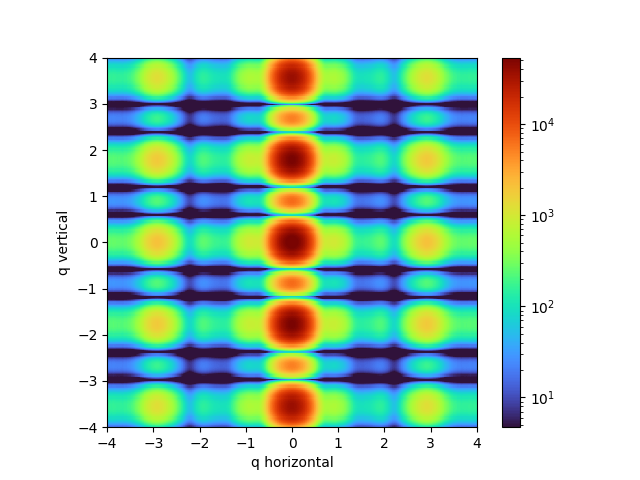

In [13]:
%matplotlib widget
fig, ax1 = subplots()
cax = ax1.imshow(det_sum,
           norm=matplotlib.colors.LogNorm(vmin=np.percentile(det_sum, 10), vmax=np.percentile(det_sum, 99.9)),
           extent=(np.min(det_h),np.max(det_h),np.min(det_v),np.max(det_v)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('q horizontal')
ax1.set_ylabel('q vertical')
# ax1.set_xlim(left=0)
# ax1.set_ylim(bottom=0)
cbar = fig.colorbar(cax, ax=ax1)

# Visualize each individual detector across angles

In [ ]:
%matplotlib inline
plt.close('all')
### load from previous results
dirr = os.getcwd()
save_path = f'{dirr}/det_output_files/'
det_h = np.load(f'{save_path}det_h.npy')
det_v = np.load(f'{save_path}det_v.npy')
det_paths = glob.glob(f'{save_path}det_psi*.npy')

for i, det_path in enumerate(det_paths):
    det_int = np.load(det_path)
    fig, ax1 = subplots()
    cax = ax1.imshow(det_int,
           norm=matplotlib.colors.Normalize(vmin=np.percentile(det_int, 10), vmax=np.percentile(det_int, 99)),
           extent=(np.min(det_h),np.max(det_h),np.min(det_v),np.max(det_v)),
           cmap='turbo',
           origin = 'lower')
    ax1.set_xlabel('q horizontal')
    ax1.set_ylabel('q vertical')
    # ax1.set_xlim(0, 3)
    # ax1.set_ylim(0, 3)
    cbar = fig.colorbar(cax, ax=ax1)
    ax1.set_title(f'Phi = {i*3} degrees')
    plt.show()
    plt.close('all')
    

In [ ]:
dirr = os.getcwd()
save_path = f'{dirr}/det_output_files/'
det_int = np.load(f'{save_path}det_psi0_phi80.npy')
det_h = np.load(f'{save_path}det_h.npy')
det_v = np.load(f'{save_path}det_v.npy')

fig, ax1 = subplots(1,1)
cax = ax1.imshow(det_int,
           norm=matplotlib.colors.Normalize(vmin=np.percentile(det_int, 10), vmax=np.percentile(det_int, 99)),
           extent=(np.min(det_h),np.max(det_h),np.min(det_v),np.max(det_v)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('q horizontal')
ax1.set_ylabel('q vertical')
# ax1.set_xlim(left=0)
# ax1.set_ylim(bottom=0)
cbar = fig.colorbar(cax, ax=ax1)
plt.tight_layout()

# Compare to experimental data

In [ ]:
%matplotlib widget
#path to background image and axes files from pyFAI output
img_name = 'TC11'
dirr = os.getcwd()
exp_path = f'{dirr}/example_giwaxs/'
img_path = f'{exp_path}{img_name}_th0.15_qmap.tif'
qxy_path = f'{exp_path}{img_name}_th0.15_qxy.txt'
qz_path = f'{exp_path}{img_name}_th0.15_qz.txt'

exp_img = fabio.open(img_path).data
exp_qxy = np.loadtxt(qxy_path)
exp_qz = np.loadtxt(qz_path)

exp_img, exp_qxy, exp_qz = mirror_qmap_positive_qxy_only(exp_img, exp_qxy, exp_qz)


save_path = f'{dirr}/det_output_files/'
det_h = np.load(f'{save_path}det_h.npy')
det_v = np.load(f'{save_path}det_v.npy')
det_sum = np.load(glob.glob(f'{save_path}det_sum.npy')[0])

det_sum = mask_forbidden_pixels(det_sum, det_h, det_v, 0.15, 12700)
qmap_compare = rebin_and_combine_qmaps(exp_img, exp_qxy, exp_qz, det_sum, det_h, det_v)

fig,ax=plt.subplots(figsize=(10,5))
cax = ax.imshow(qmap_compare,
           norm=matplotlib.colors.Normalize(vmin=np.percentile(qmap_compare, 50), vmax=np.percentile(qmap_compare, 99.5)),
           extent=(np.min(exp_qxy),np.max(exp_qxy),np.min(exp_qz),np.max(exp_qz)),
           cmap='turbo',
           origin = 'lower')
ax.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)',fontsize=16)
ax.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)',fontsize=16)